In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from functools import partial

params = pd.read_csv('2024-10-15_Kou_calibration_result.csv', header=0, index_col=0).T

r         = 0
sigma     = float(params.sigma[0])
_lambda   = float(params['lambda'][0])
S0        = float(params['spot_price'][0])
eta1      = 1/float(params['eta_p'][0])
eta2      = 1/float(params['eta_m'][0])
p         = float(params['p'][0])
q         = 1-p
T         = 365/365
M         = 365*3
dt        = T/M
N         = 5_000
k_folds    = 5

LTVH = 0.9
LP   = 0.05
LTV0 = 0.3

H  = S0*LTV0/LTVH     # Barrier level

/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_16373/3476864575.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma     = float(params.sigma[0])
/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_16373/3476864575.py:11: FutureWarning: Series.__getitem__ treating key

In [3]:
kappa_hats = pd.read_csv('kappa_hats.csv', index_col=0)
optionPrice = pd.read_csv('optionPrice.csv', index_col = 0)

In [4]:
LTV0_arr = np.unique(kappa_hats.LTV0)
startStep_arr = np.unique(kappa_hats.startStep)
endStep_arr =   np.unique(kappa_hats.endStep)
kappa_arr = np.unique(optionPrice.kappa)

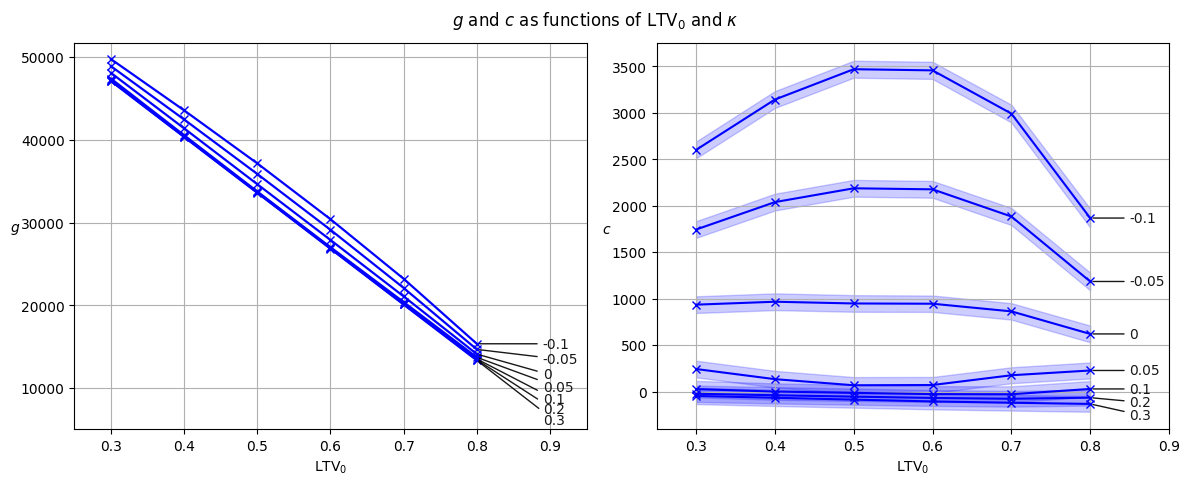

In [5]:
q = scipy.stats.norm.ppf(0.95)

plt.figure(figsize=(12,9))

ax1 = plt.subplot(2, 2, 1, frameon=True)
ax2 = plt.subplot(222, frameon=True)
ax1.grid(True)
ax2.grid(True)


# ax2.annotate('Something', xy=(0.5, 45000), xytext=(0.5, 50000), 
#             textcoords='offset points', ha='center', va='bottom',
#             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
#                             color='red'))


for ki, kappa in enumerate([-0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.3]):
    toPlot = optionPrice.query(f'kappa == {kappa} and startStep == 12 and endStep == 1095')
    
    ax1.plot(toPlot.LTV0, toPlot.loc[:, 'mean'], marker='x', color='blue')

    uq = toPlot.loc[:, 'mean'] + q*toPlot.loc[:, 'std']/np.sqrt(N*k_folds)
    lq = toPlot.loc[:, 'mean'] - q*toPlot.loc[:, 'std']/np.sqrt(N*k_folds)
    ax1.fill_between(toPlot.LTV0, uq, lq, alpha = 0.2, color='blue')
    # ax1.text(s=kappa, x=0.81, y= toPlot.loc[:, 'mean'].iloc[-1],  horizontalalignment='left', verticalalignment='center')
    
    
    ax1.annotate(kappa, xy=(0.8, toPlot.loc[:, 'mean'].iloc[-1]), xytext=(0.89, toPlot.loc[:, 'mean'].iloc[-1]-ki*1200),
                            arrowprops=dict(arrowstyle='-', color='black', alpha=0.9),alpha=0.9, 
                            ha='left', va='center')

    
    ax2.plot(toPlot.LTV0, toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0, marker='x', color='blue')

    uq = toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0 + q*toPlot.loc[:, 'std']/np.sqrt(N*k_folds)
    lq = toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0 - q*toPlot.loc[:, 'std']/np.sqrt(N*k_folds)
    
    # ax2.text(s=kappa, x=0.81, y= (toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0).iloc[-1],  horizontalalignment='left', verticalalignment='center')
    
        
    ax2.annotate(kappa, xy=(0.8, (toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0).iloc[-1]), 
                    xytext=(0.85, (toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0).iloc[-1]-(kappa==0.3) * ki * 20-(kappa==0.2) * ki * 10),
                            arrowprops=dict(arrowstyle='-', color='black', alpha=0.9),alpha=0.9, 
                            ha='left', va='center')
    
    ax2.fill_between(toPlot.LTV0, uq, lq, alpha = 0.2, color='blue')
    
ax1.set_xlim(0.25, 0.95)
ax2.set_xlim(0.25, 0.9)
ax1.set_ylim(5000, None)
plt.suptitle(r'$g$ and $c$ as functions of LTV$_0$ and $\kappa$')

ax1.set_xlabel(r'LTV$_0$')
ax2.set_xlabel(r'LTV$_0$')

ax1.set_ylabel(r'$g$', rotation=0)
ax2.set_ylabel(r'$c$', rotation=0)


plt.tight_layout()
plt.savefig('contract_values.pdf', transparent=True)



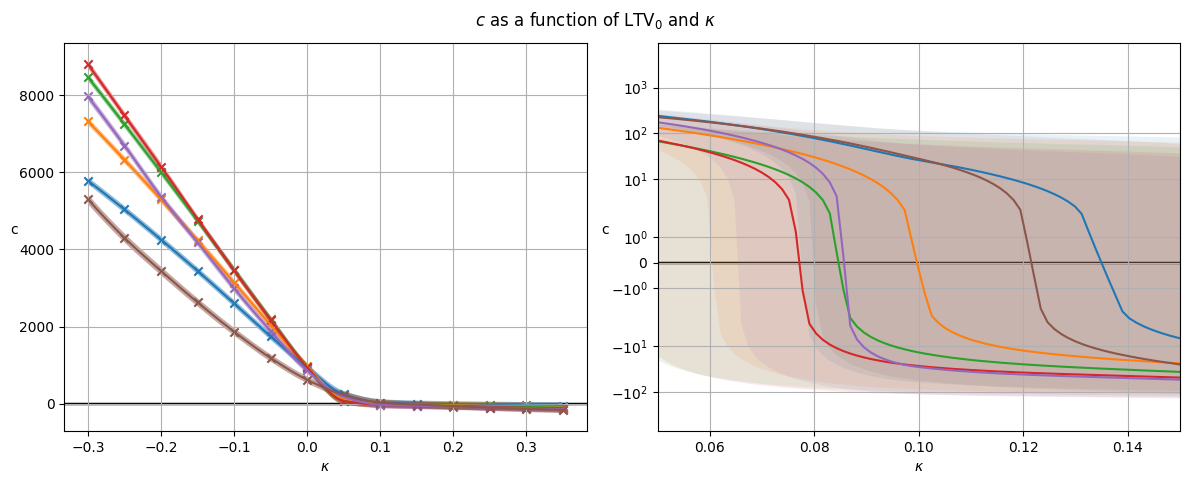

In [6]:
interpolator = scipy.interpolate.PchipInterpolator

plt.figure(figsize=(12,9))
ax1 = plt.subplot(2, 2, 1, frameon=True)
ax4 = plt.subplot(2, 2, 2, frameon=True)
# ax3 = plt.subplot(223, frameon=True)
# ax4 = plt.subplot(224, frameon=True)

ax1.grid(True)
# ax2.grid(True)
# ax3.grid(True)
ax4.grid(True)

kappa_toPlot = np.linspace(min(kappa_arr), max(kappa_arr), 500)

for LTV0 in LTV0_arr:
    toPlot = optionPrice.query(f'LTV0 == {LTV0} and startStep == 12 and endStep == 1095')

    cs = interpolator(toPlot.loc[:, 'kappa'], toPlot.loc[:, 'mean']-S0+S0*LTV0)

    uq = toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0 + q*toPlot.loc[:, 'std']/np.sqrt(N*k_folds)
    lq = toPlot.loc[:, 'mean']-S0+S0*toPlot.LTV0 - q*toPlot.loc[:, 'std']/np.sqrt(N*k_folds)

    cs_uq = interpolator(toPlot.loc[:, 'kappa'], uq)
    cs_lq = interpolator(toPlot.loc[:, 'kappa'], lq)

    collection = ax1.plot(kappa_toPlot, cs(kappa_toPlot), label=LTV0)
    ax1.fill_between(kappa_toPlot, cs_uq(kappa_toPlot), cs_lq(kappa_toPlot), alpha=0.5)
    ax1.axhline(0, color='black', zorder=-1)
    ax1.scatter(toPlot.kappa, toPlot.loc[:, 'mean']-S0+S0*LTV0, marker='x', color=collection[0].get_color())
    
    # ax2.plot(kappa_toPlot, cs(kappa_toPlot), label=LTV0)
    # ax2.fill_between(kappa_toPlot, cs_uq(kappa_toPlot), cs_lq(kappa_toPlot), alpha=0.05)
    # ax2.axhline(0, color='black', zorder=-1)

    
    # collection = ax3.plot(kappa_toPlot, cs(kappa_toPlot), label=LTV0)
    # ax3.fill_between(kappa_toPlot, cs_uq(kappa_toPlot), cs_lq(kappa_toPlot), alpha=0.05)
    # ax3.axhline(0, color='black', zorder=-1)
    # ax3.scatter(toPlot.kappa, toPlot.loc[:, 'mean']-S0+S0*LTV0, marker='x', color=collection[0].get_color())
    
    ax4.plot(kappa_toPlot, cs(kappa_toPlot), label=LTV0)
    ax4.fill_between(kappa_toPlot, cs_uq(kappa_toPlot), cs_lq(kappa_toPlot), alpha=0.1)
    ax4.axhline(0, color='black', zorder=-1)

# ax3.set_ylim(-100,200)

# ax2.set_yscale('symlog')
ax4.set_yscale('symlog')

# ax3.set_xlim(0.05,0.15)
ax4.set_xlim(0.05,0.15)

# ax1.legend()
# ax2.legend()\
# ax3.legend()
# ax4.legend()


# ylabel = r'$g-S_0+S_0$LTV$_0$'
ylabel = 'c'
ax1.set_ylabel(ylabel, rotation=0)
# ax2.set_ylabel(ylabel, rotation=0)
# ax3.set_ylabel(ylabel, rotation=0)
ax4.set_ylabel(ylabel, rotation=0)

ax1.set_xlabel(r'$\kappa$')
# ax2.set_xlabel(r'$\kappa$')
# ax3.set_xlabel(r'$\kappa$')
ax4.set_xlabel(r'$\kappa$')

plt.suptitle(r'$c$ as a function of LTV$_0$ and $\kappa$')
plt.tight_layout()
plt.savefig('contract_values_kappa_in_x.pdf', transparent=True)


In [7]:

from matplotlib import cbook, cm
from matplotlib.colors import LightSource


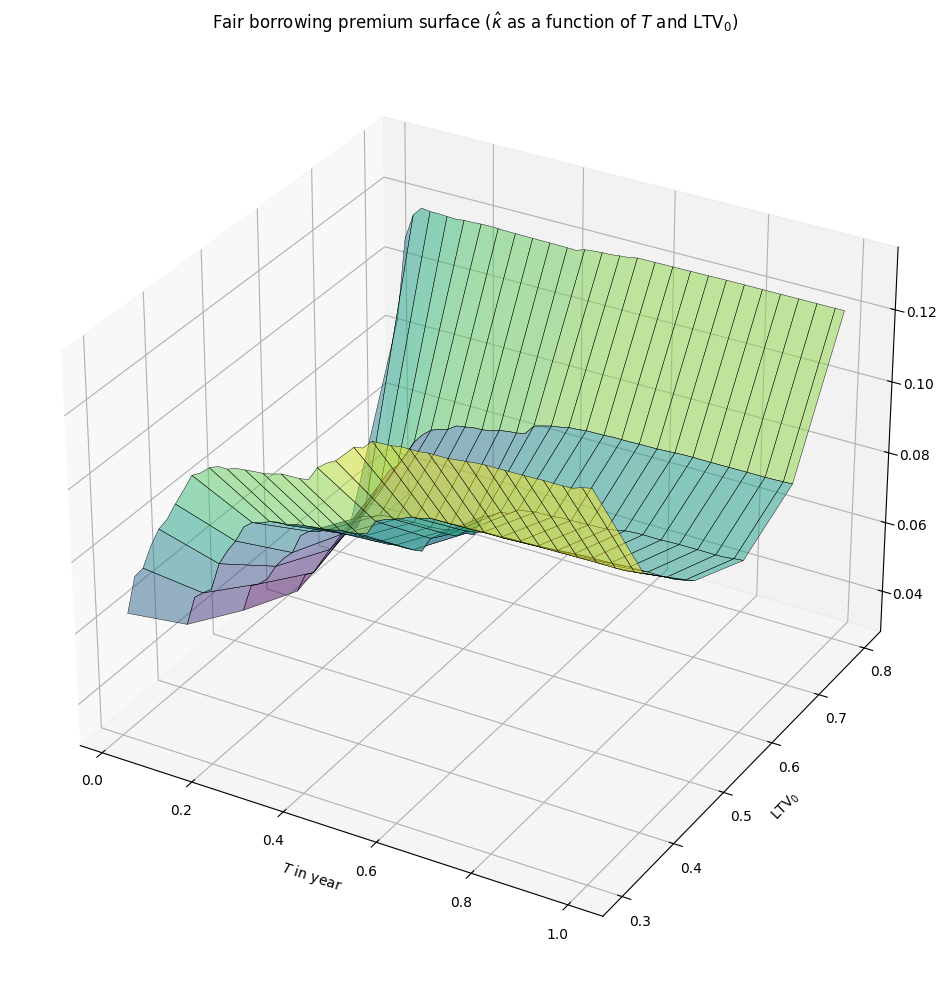

In [8]:
toPlot = kappa_hats.query(f'startStep == 12')
toPlot = toPlot.pivot(columns='maturity', index='LTV0')['kappa_hat']

z = toPlot.to_numpy()

x = toPlot.columns
y = toPlot.index

x, y = np.meshgrid(x, y)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,10))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.terrain, vert_exag=.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=1, antialiased=True, alpha=0.5, edgecolors='k', lw=0.3)

ax.set_xlabel(r'$T$ in year')
ax.set_ylabel(r'LTV$_0$')

ax.view_init(elev=30, azim=-90+30, roll=0)
plt.suptitle(r'Fair borrowing premium surface ($\hat \kappa$ as a function of $T$ and LTV$_0$)')
plt.tight_layout()
plt.savefig('surface.pdf', transparent=True)


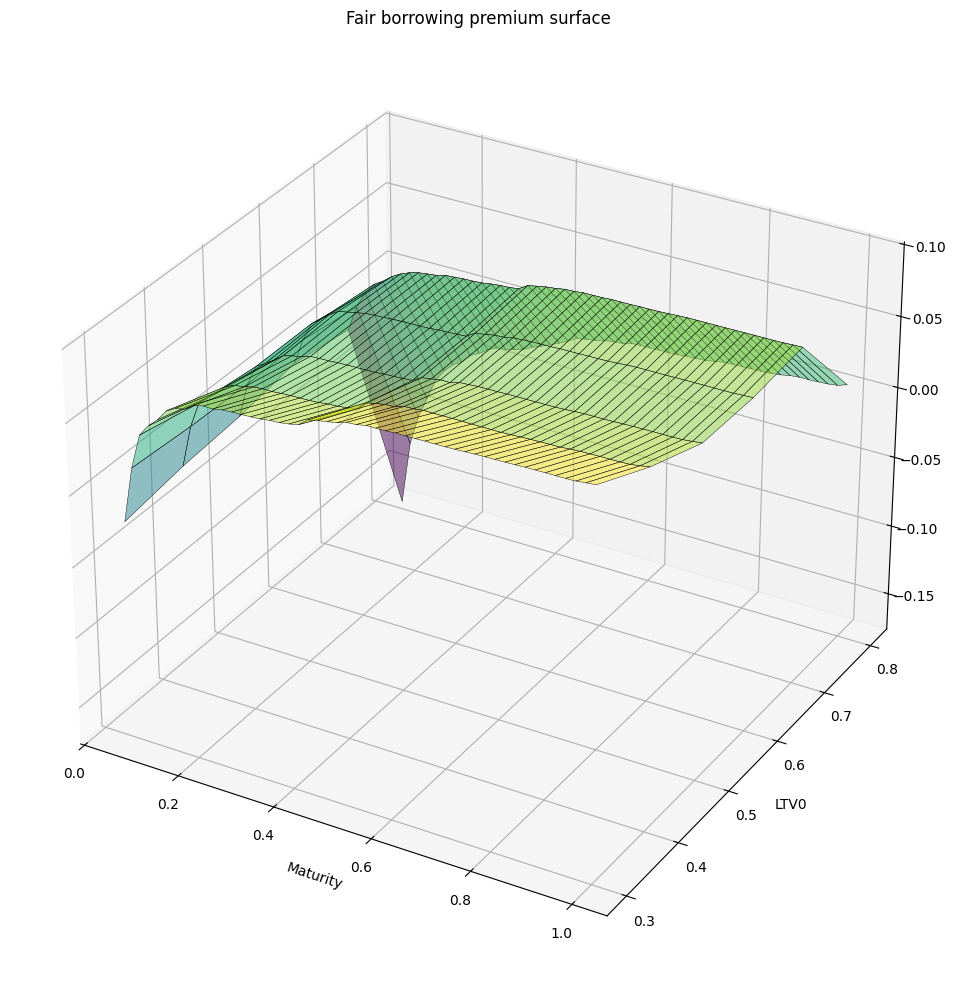

In [9]:
toPlot = kappa_hats.query(f'startStep == 60')
toPlot = toPlot.pivot(columns='maturity', index='LTV0')['kappa_hat']

z = toPlot.to_numpy()

x = toPlot.columns
y = toPlot.index

x, y = np.meshgrid(x, y)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,10))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.terrain, vert_exag=.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=1, antialiased=True, alpha=0.5, edgecolors='k', lw=0.3)

ax.set_xlabel('Maturity')
ax.set_ylabel('LTV0')

ax.view_init(elev=30, azim=-90+30, roll=0)
plt.suptitle('Fair borrowing premium surface')
plt.tight_layout()
plt.savefig('surface2.pdf', transparent=True)


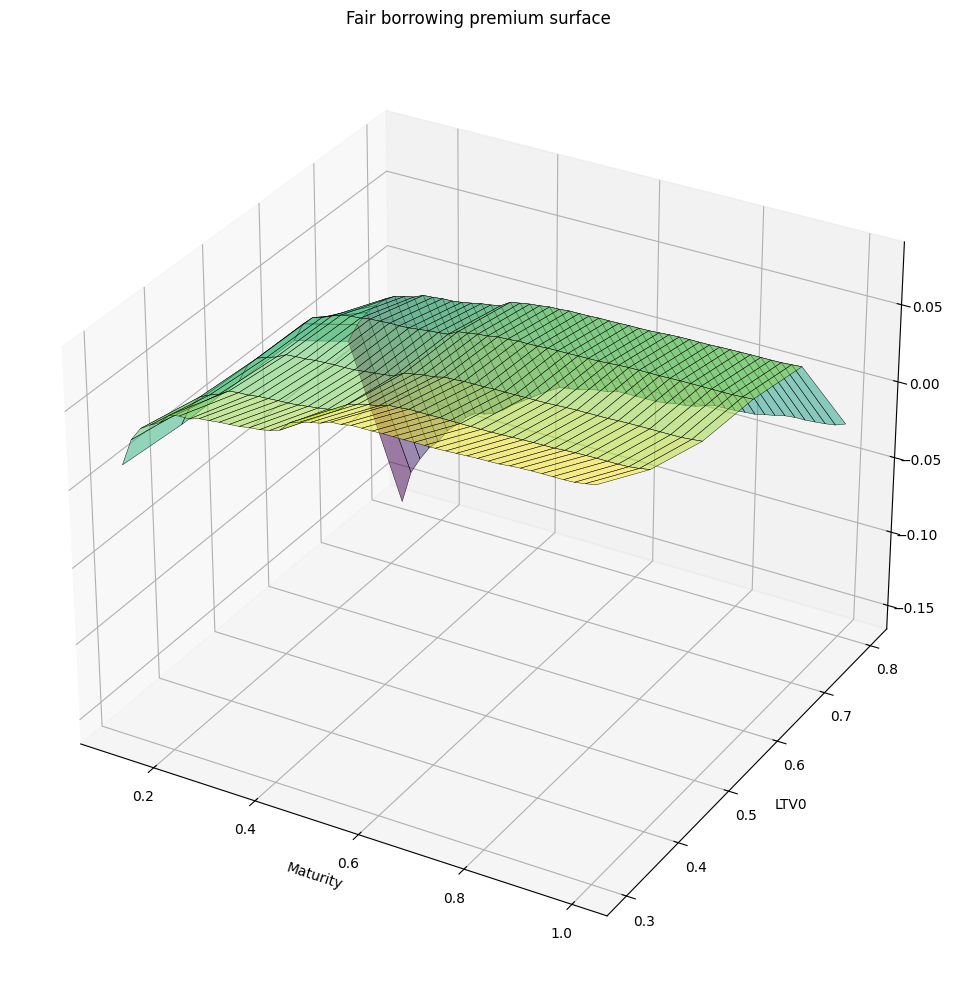

In [10]:
toPlot = kappa_hats.query(f'startStep == 120')
toPlot = toPlot.pivot(columns='maturity', index='LTV0')['kappa_hat']

z = toPlot.to_numpy()

x = toPlot.columns
y = toPlot.index

x, y = np.meshgrid(x, y)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,10))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.terrain, vert_exag=.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=1, antialiased=True, alpha=0.5, edgecolors='k', lw=0.3)

ax.set_xlabel('Maturity')
ax.set_ylabel('LTV0')

ax.view_init(elev=30, azim=-90+30, roll=0)
plt.suptitle('Fair borrowing premium surface')
plt.tight_layout()
plt.savefig('surface2.pdf', transparent=True)


In [ ]:
kappa_hats_list = []

for startStep in np.unique(kappa_hats.startStep):
    for endStep in np.unique(kappa_hats.endStep):
        for LTV0 in np.unique(kappa_hats.LTV0):
            df = optionPrice.query(f'startStep == {startStep} and endStep == {endStep} and LTV0 == {LTV0}')
            try:
                cs = interpolator(df.loc[:, 'kappa'], df.loc[:, 'mean']-S0+S0*df.LTV0)
                kappa_hat = cs.roots()
                kappa_hat = kappa_hat[np.logical_and(kappa_hat>= min(kappa_arr), kappa_hat<= max(kappa_arr))]
                
                cs = interpolator(df.loc[:, 'kappa'], df.loc[:, 'lq']-S0+S0*df.LTV0)
                lq = cs.roots()
                lq = lq[np.logical_and(lq >= min(kappa_arr), lq <= max(kappa_arr))]
                
                cs = interpolator(df.loc[:, 'kappa'], df.loc[:, 'lq']-S0+S0*df.LTV0)
                uq = cs.roots()
                uq = uq[np.logical_and(uq >= min(kappa_arr), uq <= max(kappa_arr))]

                kappa_hats_list.append([startStep, endStep, LTV0, kappa_hat, lq, uq])
            except:
                print(startStep, endStep, LTV0)
            

In [11]:
plt.figure(figsize=(12,9))
kappa_hats_cfs = pd.DataFrame(kappa_hats_list)
kappa_hats_cfs.columns = ['startStep', 'endStep', 'LTV0', 'kappa_hat', 'lq', 'uq']

kappa_hats_cfs_EU = pd.DataFrame(kappa_hats_list_EU)
kappa_hats_cfs_EU.columns = ['startStep', 'endStep', 'LTV0', 'kappa_hat', 'lq', 'uq']

plt.plot(kappa_hats_cfs.LTV0, kappa_hats_cfs.kappa_hat, marker='x')
plt.fill_between(kappa_hats_cfs.LTV0, kappa_hats_cfs.lq, kappa_hats_cfs.uq, alpha=0.3)

plt.grid(True)
plt.xlabel(r'LTV$_0$')
plt.ylabel(r'$\hat\kappa$', rotation=0)
plt.title(r'Fair borrowing premium as a function of LTV$_0$')
plt.savefig('kappa_hat_vs_LTV0.pdf', transparent=True)
# plt.plot(kappa_hats_cfs_EU.LTV0, kappa_hats_cfs_EU.kappa_hat, marker='x')
# plt.fill_between(kappa_hats_cfs_EU.LTV0, kappa_hats_cfs_EU.lq, kappa_hats_cfs_EU.uq, alpha=0.3)

NameError: name 'kappa_hats_list' is not defined

<Figure size 1200x900 with 0 Axes>